In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from scipy import signal
from scipy import io
import matplotlib.image as mpimg
from random import randint
from PIL import Image


In [32]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

def get_batch(batch_size, kernels, load_mem, data=None):
    y = None # y is the set of sharp patches
    if(load_mem):
        y = data['y']
    
    training_patches_dir = '../../data/VOC2012_patches/training'    
    
    num_img = 12500
    num_patches_per_img = 40
    num_patches = num_img*num_patches_per_img
    num_kernels = kernels.shape[2] # kernels = [41,41, num_kernels]
    
    x_batch = []
    y_flat_true_batch = []
    k_batch = []
    
    
    for i in range(batch_size):
        # Select a kernel
        k_idx = randint(0, num_kernels-1)
        img_s = None
        
        # Load from memory
        # !!!!! MAKE SURE YOU MAKE THESE IMAGES GRAYSCALE !!!!!
        if(load_mem):
            patch_idx = randint(0, num_patches-1)
            img_s = y[patch_idx]
        # Loading from disk
        else:
            img_idx = randint(0, num_img-1)
            p_idx = randint(0, num_patches_per_img-1)
            patch_file = training_patches_dir + '/patch_'+str(img_idx)+'_'+str(p_idx)+'.jpg'
            pil_img_o = Image.open(patch_file).convert('L')
            img_s = np.asarray(pil_img_o)
        
        # Get kernel and generate blury image
        k = kernels[:,:,k_idx] 
        img_b = signal.convolve2d(img_s, k, mode='same')
        
        img_flat_size = img_s.shape[0]**2
        img_s_flat = img_s.reshape((img_flat_size))
        
        # add x,y,k to batch
        x_batch.append(img_b)
        y_flat_true_batch.append(img_s_flat)
        k_batch.append(k)
        
    
    return np.array(x_batch), np.array(y_flat_true_batch), np.array(k_batch)

In [33]:

# Data will come in batches 
#data = input_data.read_data_sets('data/MNIST/', one_hot=True)
o = io.loadmat('../../data/kernels/train_kernels.mat')
kernels = o['kernels']
training_patches_dir = '../../data/VOC2012_patches/training'

# We know that MNIST images are 28 pixels in each dimension.
img_size = 105

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)


# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = img_size_flat   # Number of neurons in fully-connected layer.



# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Size of the output sharp patch
output_size = img_size_flat


train_batch_size = 8

# Counter for total number of iterations performed so far.
total_iterations = 0

# Split the test-set into smaller batches of this size.
test_batch_size = 8



# FIX NETWORK OUTPUT TOPOLOGY

## Building the graph for the Neural network with placeholders ONLY

x = tf.placeholder(tf.float32, shape=[train_batch_size, img_size, img_size, num_channels], name='x')

y_flat_true = tf.placeholder(tf.float32, shape=[None, output_size], name='y_true')


layer_conv1, weights_conv1 = \
    new_conv_layer(input=x,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

#layer_conv2, weights_conv2 = \
#    new_conv_layer(input=layer_conv1,
#                   num_input_channels=num_filters1,
#                   filter_size=filter_size2,
#                   num_filters=num_filters2,
#                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv2)


#layer_fc1 = new_fc_layer(input=layer_flat,
#                         num_inputs=num_features,
#                         num_outputs=fc_size,
#                         use_relu=True)

output = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=output_size,
                         use_relu=False)
y_flat_pred = output

cost = tf.reduce_mean(tf.square(y_flat_pred-y_flat_true))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)



In [34]:

def optimize(optimizer, cost, num_iterations, kernels, data=None, load_mem=False):
    # num_iterations is the number of iters to add onto how many have already been done
    
    ## Initializing a session for the neural network
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        
        x_batch, y_flat_true_batch, k_batch = get_batch(train_batch_size, kernels, load_mem, data)
        feed_dict_train = {x: x_batch,
                           y_flat_true: y_flat_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 1 == 0:
            # Calculate the accuracy on the training-set.
            cost_val = session.run(cost, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Cost: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, cost_val))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))


In [35]:
#print_test_accuracy()
optimize(optimizer, cost, num_iterations=1, kernels=kernels)
optimize(optimizer, cost, num_iterations=9, kernels=kernels) # We already performed 1 iteration above.
#print_test_accuracy()


ResourceExhaustedError: OOM when allocating tensor of shape [11025,11025] and type float
	 [[Node: Variable_30/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [11025,11025] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'Variable_30/Adam/Initializer/zeros', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/adrian/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/adrian/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/adrian/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/adrian/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/adrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/adrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/adrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/adrian/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/adrian/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/adrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/adrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/adrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/adrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-6dce0f35be50>", line 84, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 424, in minimize
    name=name)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 600, in apply_gradients
    self._create_slots(var_list)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/adam.py", line 131, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 1150, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1317, in get_variable
    constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1079, in get_variable
    constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 786, in _get_single_variable
    use_resource=use_resource)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2220, in variable
    use_resource=use_resource)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2210, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2193, in default_variable_creator
    constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 343, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 770, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 99, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1626, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2717, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/adrian/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [11025,11025] and type float
	 [[Node: Variable_30/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [11025,11025] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


(11025,)


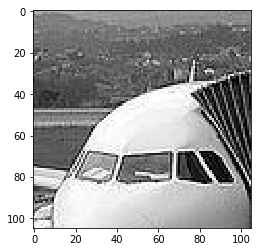

In [14]:
patch_file = '../../data/VOC2012_patches/training' + '/patch_'+str(0)+'_'+str(0)+'.jpg'
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

jpgfile = Image.open(patch_file).convert('L')
img_s = np.asarray(jpgfile)
plt.imshow(img_s, cmap= 'gray')

img_flat_size = img_s.shape[0]**2
img_flat = img_s.reshape((img_flat_size))
print(img_flat.shape)

(3, 41, 41)


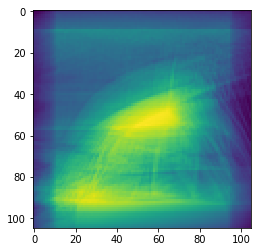

In [13]:
o = io.loadmat('../../data/kernels/train_kernels.mat')
kernels = o['kernels']

k = kernels[:,:,0]

img_b = signal.convolve(img_s, k, mode = 'same')

plt.imshow(img_b)


arr = []
arr.append(kernels[:,:,0])
arr.append(kernels[:,:,1])
arr.append(kernels[:,:,2])

anp = np.array(arr)
print(anp.shape)